In [1]:
import pandas as pd
from PIL import Image, ImageFilter
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-16 01:56:30.535442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_labels = pd.read_csv("traininglabels.csv")
train_labels['image_id'] = train_labels['image_id'].str.replace('2017', '', regex=False)
train_labels['image_id'] = train_labels['image_id'].str.replace('2018', '', regex=False)
train_labels['has_oilpalm'] = train_labels['has_oilpalm'].astype(str)

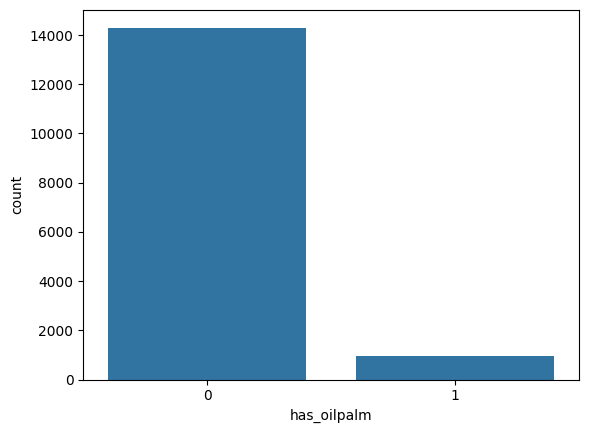

In [3]:
histo = sns.countplot(x="has_oilpalm", data=train_labels)

In [4]:
positive_class_files = train_labels[(train_labels["has_oilpalm"] == "1") & (train_labels["score"] > 0.5)]
negative_class_files = train_labels[(train_labels["has_oilpalm"] == "0") & (train_labels["score"] == 1.0000)]
'''Wanted to create a higher level of certainty by only including items in the positive class that had a score of 0.5 or higher,
and only including items in the negative class that had a score of 1.0'''

'Wanted to create a higher level of certainty by only including items in the positive class that had a score of 0.5 or higher,\nand only including items in the negative class that had a score of 1.0'

In [5]:
print(len(positive_class_files))
print(len(negative_class_files))

920
11955


The data his heavily biased towards the negative class by a split of 93/7, so we need to reduce bias by either undersampling or oversampling. So I decided to oversample the positive class so as to not lose any potentially useful data. But first I want to create a test set from our training data.

In [6]:
test_split = pd.concat([positive_class_files, negative_class_files])

I'm taking a random split of 20% of the total data to use as my final testing data set.

In [7]:
train, val = train_test_split(test_split, test_size=0.2,random_state=42)

In [48]:
#final test set
#positive_class_test = test[test['has_oilpalm'] == "1"]['image_id'].to_list()
#negative_class_test = test[test['has_oilpalm'] == "0"]['image_id'].to_list()

And here I am creating a validation set so I can train my loss function values in the training step of my CNN to find the best epoch in the event of early stoppage.

In [31]:
#train, val = train_test_split(train,test_size=0.2,random_state=42)

In [8]:
#validation set
positive_class_val = val[val['has_oilpalm'] == "1"]['image_id'].to_list()
negative_class_val = val[val['has_oilpalm'] == "0"]['image_id'].to_list()

In [9]:
#training set
positive_class_files = train[train["has_oilpalm"] == "1"]['image_id'].to_list()
negative_class_files = train[train["has_oilpalm"] == "0"]['image_id'].to_list()

In [10]:
pos_count = len(positive_class_files)
neg_count = len(negative_class_files)
pos_count, neg_count

(731, 9569)

In [115]:
weight_pos = 1 / pos_count
weight_neg = 1 / neg_count
weight_pos, weight_neg

(0.0017482517482517483, 0.00013041210224308815)

This function is used to oversample to positive class by augmenting the images using various methods such as simple rotation as well as ImageFilters from the Pillow library. This resampling reduced bias to a 59.8/40.2 split, still in favor of the negative class.

In [11]:
def read_image(file_path,positive_class_files,negative_class_files):
  positive_image_arrays = []
  positive_image_names = []
  negative_image_names = []
  negative_image_arrays = []
  os.listdir(file_path)
  for jpg in os.listdir(file_path):
    if jpg.endswith(".jpg"):
      if jpg in positive_class_files:
        #original name
        positive_image_names.append(jpg)
        jpg2 = jpg.split(".")
        #rotated 45 name
        rotated = jpg2[0] + "_rotated_45" + "." + jpg2[1]
        positive_image_names.append(rotated)
        #blurred name
        blurred = jpg2[0] + "_blurred" + "." + jpg2[1]
        positive_image_names.append(blurred)
        #rotated blurred name
        rotate_blur = jpg2[0] + "rotated_blurred" + "." + jpg2[1]
        positive_image_names.append(rotate_blur)
        #sharpened name
        sharpen = jpg[0] + "sharpened" + "." + jpg2[1]
        positive_image_names.append(sharpen)
        #rotated sharpened name
        rotate_sharpen = jpg[0] + "rotated_sharp" + "." + jpg2[1]
        positive_image_names.append(rotate_sharpen)
        #flipped 180 name
        rotate_180 = jpg2[0] + "_rotated_180" + "." + jpg2[1]
        positive_image_names.append(rotate_180)
        #rotate 180 blur name
        rotate_180_blur = jpg2[0] + "_rotated_180_blur" + "." + jpg2[1]
        positive_image_names.append(rotate_180_blur)
        #rotate 180 sharpen image array
        rotate_180_sharp = rotate_180_blur = jpg2[0] + "_rotated_180_sharp" + "." + jpg2[1]
        positive_image_names.append(rotate_180_sharp)
        img_path = os.path.join(file_path,jpg)
        img = image.load_img(img_path,target_size=(224,224))
        #original image array
        img_array = (image.img_to_array(img))/255
        positive_image_arrays.append(img_array)
        #rotated 45 degrees image array
        img_rot = img.rotate(45,expand=False)
        img_array1 = (image.img_to_array(img_rot))/255
        positive_image_arrays.append(img_array1)
        #blurred image array
        img_blur = img.filter(ImageFilter.BLUR)
        img_array2 = (image.img_to_array(img_blur))/255
        positive_image_arrays.append(img_array2)
        #rotate 45 blurred image array
        img_rot_blur = img.rotate(45,expand=False)
        img_rot_blur = img_rot_blur.filter(ImageFilter.BLUR)
        img_array3 = (image.img_to_array(img_rot_blur))/255
        positive_image_arrays.append(img_array3)
        #sharpened image array
        img_sharpen = img.filter(ImageFilter.SHARPEN)
        img_array4 = (image.img_to_array(img_sharpen))/255
        positive_image_arrays.append(img_array4)
        #rotated 45 sharpened image array
        img_sharp_rot = img.rotate(45,expand=False)
        img_sharp_rot = img_sharp_rot.filter(ImageFilter.SHARPEN)
        img_array5 = (image.img_to_array(img_sharp_rot))/255
        positive_image_arrays.append(img_array5)
        #rotate 180 image array
        image_rot_180 = img.rotate(180,expand=False)
        img_array6 = (image.img_to_array(image_rot_180))/255
        positive_image_arrays.append(img_array6)
        #rotate 180 blur image array
        image_rot_180_blur = img.rotate(180,expand=False)
        image_rot_180_blur = image_rot_180_blur.filter(ImageFilter.BLUR)
        img_array7 = (image.img_to_array(image_rot_180_blur))/255
        positive_image_arrays.append(img_array7)
        #rotate 180 sharpen image array
        image_rot_180_sharp = img.rotate(180,expand=False)
        image_rot_180_sharp = image_rot_180_sharp.filter(ImageFilter.SHARPEN)
        img_array8 = (image.img_to_array(image_rot_180_sharp))/255
        positive_image_arrays.append(img_array8)
      elif jpg in negative_class_files:
        negative_image_names.append(jpg)
        img_path = os.path.join(file_path,jpg)
        img = image.load_img(img_path,target_size=(224,224))
        img_array = (image.img_to_array(img))/255
        negative_image_arrays.append(img_array)
      else:
        pass
  return positive_image_arrays,positive_image_names,negative_image_arrays,negative_image_names

In [12]:
def read_image_val(file_path,positive_class_files,negative_class_files):
  positive_image_arrays = []
  positive_image_names = []
  negative_image_names = []
  negative_image_arrays = []
  os.listdir(file_path)
  for jpg in os.listdir(file_path):
    if jpg.endswith(".jpg"):
      if jpg in positive_class_files:
        #original name
        positive_image_names.append(jpg)
        jpg2 = jpg.split(".")
        img_path = os.path.join(file_path,jpg)
        img = image.load_img(img_path,target_size=(224,224))
        #original image array
        img_array = (image.img_to_array(img))/255
        positive_image_arrays.append(img_array)
      elif jpg in negative_class_files:
        negative_image_names.append(jpg)
        img_path = os.path.join(file_path,jpg)
        img = image.load_img(img_path,target_size=(224,224))
        img_array = (image.img_to_array(img))/255
        negative_image_arrays.append(img_array)
      else:
        pass
  return positive_image_arrays,positive_image_names,negative_image_arrays,negative_image_names

In [13]:
#training arrays/names
positive_image_arrays,positive_image_names,negative_image_arrays,negative_image_names = read_image("/Users/anthonyvillegas/Documents/GitHub/ds-mod-2-0924-code-solutions/cnn-palm-oil/train_images",positive_class_files,negative_class_files)

In [14]:
#validation arrays/names
positive_image_arrays_val,positive_image_names_val,negative_image_arrays_val,negative_image_names_val = read_image_val("/Users/anthonyvillegas/Documents/GitHub/ds-mod-2-0924-code-solutions/cnn-palm-oil/train_images",positive_class_val,negative_class_val)

In [15]:
#training x & y
x = np.concatenate([positive_image_arrays, negative_image_arrays])
y = np.concatenate([np.ones(len(positive_image_arrays)), np.zeros(len(negative_image_arrays))])

In [16]:
y_list = y.tolist()

In [17]:
histo_df = pd.DataFrame(y_list,columns=["has_oilpalm"])

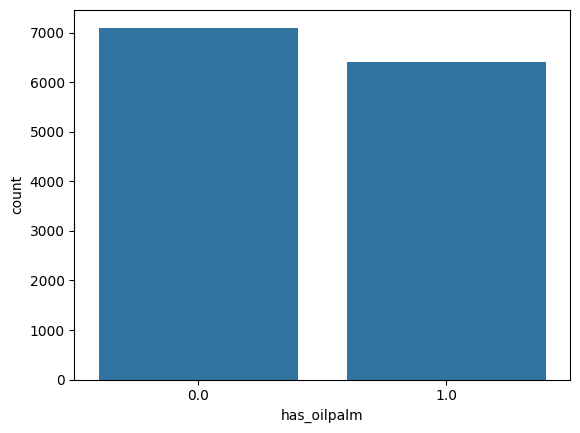

In [18]:
histo2 = sns.countplot(x="has_oilpalm", data=histo_df)

In [19]:
#validation x & y
x_val = np.concatenate([positive_image_arrays_val, negative_image_arrays_val])
y_val = np.concatenate([np.ones(len(positive_image_arrays_val)), np.zeros(len(negative_image_arrays_val))])

In [89]:
#image augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [132]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [20]:
model = keras.Sequential([
       layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
       layers.MaxPooling2D((2, 2)),
       layers.Dropout(0.3),
       layers.Conv2D(64, (3, 3), activation='relu'),
       layers.MaxPooling2D((2, 2)),
       layers.Dropout(0.3),
       layers.Flatten(),
       layers.Dense(64, activation='relu'),
       layers.Dense(1, activation='sigmoid')
   ])
#batch normalization
#dropout layers
#augmentation

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
optimizer_object = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer_object,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [29]:
history = model.fit(x, y, epochs=20, validation_data=(x_val,y_val))

: 

: 

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

AttributeError: 'History' object has no attribute 'History'